In [88]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

### Add 'hide_toggle()' in the cell to collapse

## Import Libraries

In [93]:
import numpy as np
import os, requests
from matplotlib import pyplot as plt
hide_toggle()

## Import plot functions and define parameters

In [89]:
# import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
hide_toggle()

## Load data

In [301]:
# Load Data
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:        
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)
hide_toggle()

In [302]:
# Data loading
alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])


In [308]:
dat['pupil'].shape #  (3, 340, 250) <-- (pupil area, pupil horizontal, pupil vertical), 250 time bins, 340 trials
len(dat['pupil'])
pupil_area = dat['pupil'][1,:,:]
# pupil_area.shape
len(pupil_area)

340

## Group brain regions

In [6]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

In [129]:
NT

250

## Plot: mean neural activity vs response

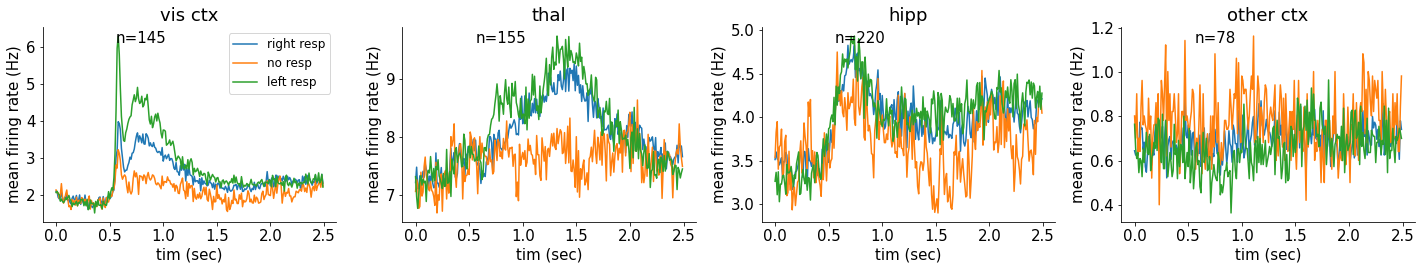

In [92]:
# plots by brain region and responses
response = dat['response'] # right - nogo - left (-1, 0, 1)

for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
  
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response>=0].mean(axis=(0,1)))
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

    if j==0:
        plt.legend(['right resp','no resp', 'left resp'], fontsize=12)
    ax.set(xlabel = 'tim (sec)', ylabel = 'mean firing rate (Hz)', title = regions[j])
hide_toggle()

### PCA (run the cells in the next ' Test PCA' section first)

In [25]:
pc1.shape

(340, 250)

In [26]:
pc1[response>0,:].shape

(135, 250)

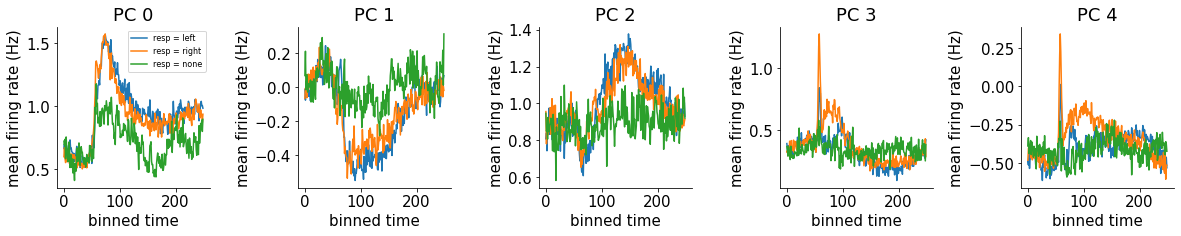

In [22]:
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
    pc1 = pc_10ms[j]
    ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)

    plt.plot(pc1[response>0, :].mean(axis=0))
    plt.plot(pc1[response<0, :].mean(axis=0))
    plt.plot(pc1[response==0, :].mean(axis=0))

    if j==0:
        plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
    ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
    plt.title('PC %d'%j)

## Plot: mean neural activity vs task difficulty

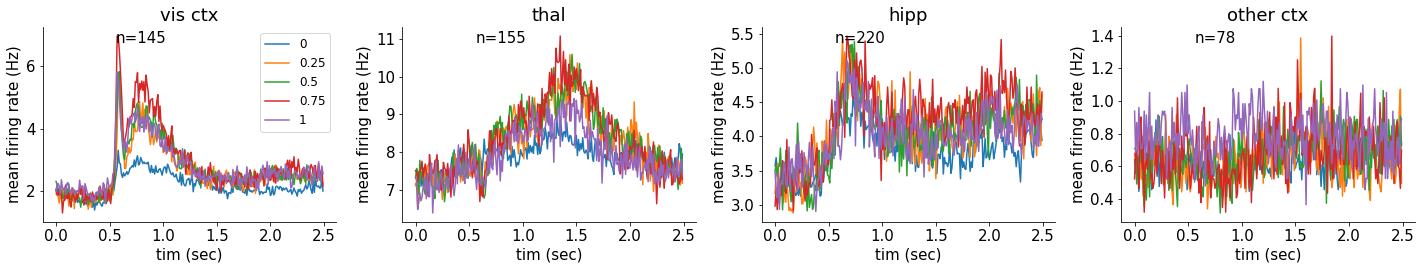

In [91]:
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

l_cont = dat['contrast_left']
r_cont = dat['contrast_right']

for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
    
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0][barea==j].mean(axis=(0,1))) # difference 0
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.25][barea==j].mean(axis=(0,1))) # difference 0.25
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.5][barea==j].mean(axis=(0,1))) # difference 0.5
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.75][barea==j].mean(axis=(0,1))) # difference 0.75
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==1][barea==j].mean(axis=(0,1))) # difference 1
  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

    if j==0:
        plt.legend(['0', '0.25', '0.5', '0.75', '1'], fontsize=12)
    ax.set(xlabel = 'tim (sec)', ylabel = 'mean firing rate (Hz)', title = regions[j])
hide_toggle()

### PCA

In [62]:
l_cont.shape

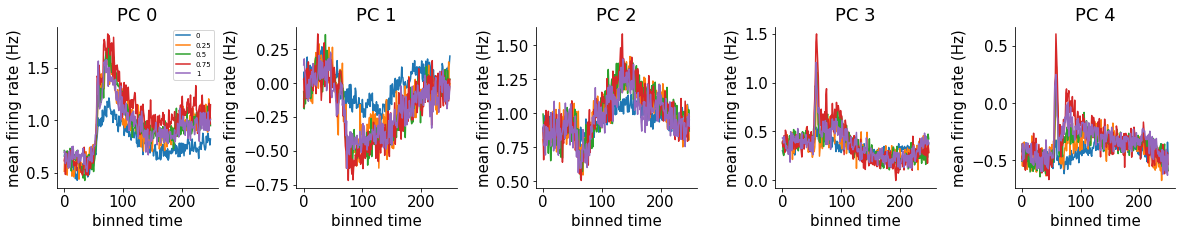

In [201]:
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
    pc1 = pc_10ms[j]
    ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)

    plt.plot(pc1[np.abs(l_cont-r_cont)==0,:].mean(axis=0))
    plt.plot(pc1[np.abs(l_cont-r_cont)==0.25,:].mean(axis=0))  
    plt.plot(pc1[np.abs(l_cont-r_cont)==0.5,:].mean(axis=0))  
    plt.plot(pc1[np.abs(l_cont-r_cont)==0.75,:].mean(axis=0))  
    plt.plot(pc1[np.abs(l_cont-r_cont)==1,:].mean(axis=0))  

    if j==0:
        plt.legend(['0', '0.25', '0.5', '0.75', '1'], fontsize=7)
    ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
    plt.title('PC %d'%j)
hide_toggle()    

## PCA of hippocampus only (test)

brain area:  hipp
diff_cont:  0.75
NNhp =  220
dr.shape:  (220, 11000)
mdl.components_.shape:  (5, 220)
pc_hp.shape: (5, 85000)
after reshaping pc_hp.shape: (5, 340, 250)


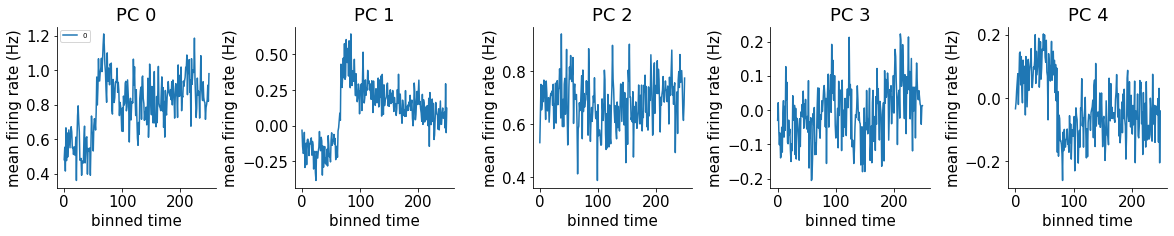

In [360]:
# brain area: 
# [visual cortex, thalamus, hippocampal, non-visual cortex, other(midbrain, basal ganglia, cortical subplate)] = [0,1,2,3,4]
j_barea = 2

# contrast difference: 
diff_cont = [0, 0.25, 0.5, 0.75 ,1]
i=3

plt.figure(figsize= (20, 6))
# =============================================================================================
NNhp = len(dat['spks'][barea==j_barea][:,np.abs(l_cont-r_cont)==diff_cont[i]]) # shape: 220, 126, 250
print('brain area: ', regions[j_barea])
print('diff_cont: ', diff_cont[i])
print('NNhp = ', NNhp) # NNhp is indep of the diff_cont. but depends on the brain area.

# original shape (contrast diff 0): (220, 126, 250)
dr = np.reshape(dat['spks'][barea==j_barea][:,np.abs(l_cont-r_cont)==diff_cont[i]], (NNhp,-1)) 
dr = dr - np.mean(dr, axis=1)[:,np.newaxis]
print('dr.shape: ', dr.shape) # dr depends on both the brain area and diff_cont.

mdl = PCA(n_components = 5).fit(dr.T)
print('mdl.components_.shape: ', mdl.components_.shape)
W = mdl.components_
pc_hp = W @ np.reshape(dat['spks'][barea==j_barea], (NNhp,-1))
print('pc_hp.shape:',pc_hp.shape)
pc_hp = np.reshape(pc_hp, (5,-1,NT))
print('after reshaping pc_hp.shape:',pc_hp.shape)
# pchp_1 = pc_hp[1]

#     plt.plot(pchp_1[np.logical_and(np.abs(l_cont-r_cont)==0), :].mean(axis=0))  
for j in range(len(pc_hp)):
    pchp1 = pc_hp[j]
    ax = plt.subplot(2,len(pc_hp)+1,len(pc_hp)+1 + j+1)

    plt.plot(pchp1[np.abs(l_cont-r_cont)==diff_cont[i],:].mean(axis=0))
#     plt.plot(pchp1[np.abs(l_cont-r_cont)==0.25,:].mean(axis=0))  
#     plt.plot(pchp1[np.abs(l_cont-r_cont)==0.5,:].mean(axis=0))  
#     plt.plot(pchp1[np.abs(l_cont-r_cont)==0.75,:].mean(axis=0))  
#     plt.plot(pchp1[np.abs(l_cont-r_cont)==1,:].mean(axis=0))  
    if j==0:
        plt.legend(['0', '0.25', '0.5', '0.75', '1'], fontsize=7)

    ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
    plt.title('PC %d'%j)

hide_toggle()

## PCA test: 5 PCs of neural activityfor different task difficulties

Define brain area:

[visual cortex, thalamus, hippocampal, non-visual cortex, other(midbrain, basal ganglia, cortical subplate)] = [0,1,2,3,4]

In [172]:
j_barea = 2

Define the contrast difference

In [173]:
diff_cont = [0, 0.25, 0.5, 0.75 ,1]

Define a function to compute PC for a given brain area and the contrast difference

In [333]:
NNhp

220

### Functions for PCA & plots

In [297]:
def compute_pc(j_barea, idx_contrast):
    i = idx_contrast
    
    # shape: (220, 126, 250) <-- this and NNhp dep. on b_area/difficulty
    NNhp = len(dat['spks'][barea==j_barea][:,np.abs(l_cont-r_cont)==diff_cont[i]]) 
    print('brain area: ', regions[j_barea])
    print('diff_cont: ', diff_cont[i])
    print('NNhp = ', NNhp) # NNhp is indep of the diff_cont. but depends on the brain area.

    # original shape (contrast diff 0): (220, 126, 250)gg
    dr = np.reshape(dat['spks'][barea==j_barea][:,np.abs(l_cont-r_cont)==diff_cont[i]], (NNhp,-1)) 
    dr = dr - np.mean(dr, axis=1)[:,np.newaxis]
    print('dr.shape: ', dr.shape) # dr depends on both the brain area and diff_cont.

    mdl = PCA(n_components = 5).fit(dr.T)
    W = mdl.components_
    pc_hp = W @ np.reshape(dat['spks'][barea==j_barea], (NNhp,-1))
    print('pc_hp.shape ', pc_hp.shape)
    pc_hp = np.reshape(pc_hp, (5,-1,NT))
    return pc_hp

In [334]:
def compute_pc_np(j_barea, idx_contrast): # same as 'compute_pc' but without printing out anything
    i = idx_contrast
    
    NNhp = len(dat['spks'][barea==j_barea][:,np.abs(l_cont-r_cont)==diff_cont[i]])

    dr = np.reshape(dat['spks'][barea==j_barea][:,np.abs(l_cont-r_cont)==diff_cont[i]], (NNhp,-1)) 
    dr = dr - np.mean(dr, axis=1)[:,np.newaxis]
    
    mdl = PCA(n_components = 5).fit(dr.T)
    W = mdl.components_
    pc_hp = W @ np.reshape(dat['spks'][barea==j_barea], (NNhp,-1))
#     print('pc_hp.shape ', pc_hp.shape)
    pc_hp = np.reshape(pc_hp, (5,-1,NT))
    return pc_hp, NNhp

In [291]:
def plot_pca(pc_hp):
    """
    make sure to have 'plt.figure(figsize= (20, 6))' before this function.
    
    """
    for j in range(len(pc_hp)):
        pchp1 = pc_hp[j]
#         ax = plt.subplot(2,len(pc_hp)+1,len(pc_hp)+1 + j+1)

        axs[j].plot(pchp1[np.abs(l_cont-r_cont)==diff_cont[idx_contrast],:].mean(axis=0))
        if j==0:
            axs[j].legend(['0', '0.25', '0.5', '0.75', '1'], fontsize=9)

#         ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
#         axs[i].set_title('PC %d'%j)

## This one works ↓

NN:  220
NN:  220
NN:  220
NN:  220
NN:  220


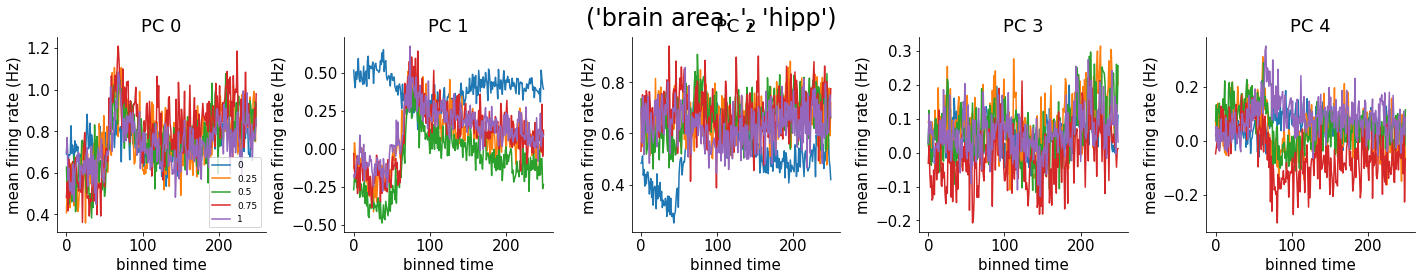

In [363]:
fig, axs = plt.subplots(1,5)
j_barea = 2
# 'brain area: ', regions[j_barea]

fig.suptitle(('brain area: ',regions[j_barea]), fontsize=24)
    
for ax in axs.flat:
    ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)')

for idx_contrast in range(len(diff_cont)):
    axs[idx_contrast].set_title('PC %d'%idx_contrast)
    
    pc_hp, NNhp = compute_pc_np(j_barea, idx_contrast)
    print('NN: ',NNhp)
#     print('--------------------')
    plot_pca(pc_hp)

# plt.tight_layout()
hide_toggle()

------------------------------------------------------------------------------------------------------------

In [44]:
# reshape the spiking data from (neurons, trials, time bins) to (neurons, trials) <-- reduce time bins?
np.reshape(dat['spks'][:,:,51:130], (NN,-1)).shape # shape = (698, 340, 79)

(698, 26860)

In [ ]:
droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

In [294]:
dat['spks'].shape[-1]

250

In [295]:
def pca_taskdiff(idx_brain_area, contrast_difference):
    
    """
    Take the index of the brain area and the contrast difference, returns pca
    """
#     NT = dat['spks'].shape[-1]
    j_barea = idx_brain_area
    
    NN_area = len(dat['spks'][barea==j_barea][:,np.abs(l_cont-r_cont)==contrast_difference]) # shape: 220, 126, 250
    dr = np.reshape(dat['spks'][barea==j_barea][:,np.abs(l_cont-r_cont)==diff_cont[i]], (NN_area,-1)) 
    dr = dr - np.mean(dr, axis=1)[:,np.newaxis]
    mdl = PCA(n_components = 5).fit(dr.T)
    W = mdl.components_
    pc_area = W @ np.reshape(dat['spks'][barea==j_barea], (NN_area,-1))
    pc_area = np.reshape(pc_area, (5,-1,NT))


    return pc_hp

## Test PCA (referenced from 'load_steinmetz_decisions.ipynb')
(https://github.com/NeuromatchAcademy/course-content/blob/master/projects/load_steinmetz_decisions.ipynb)

In [11]:
from sklearn.decomposition import PCA 

In [13]:
droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

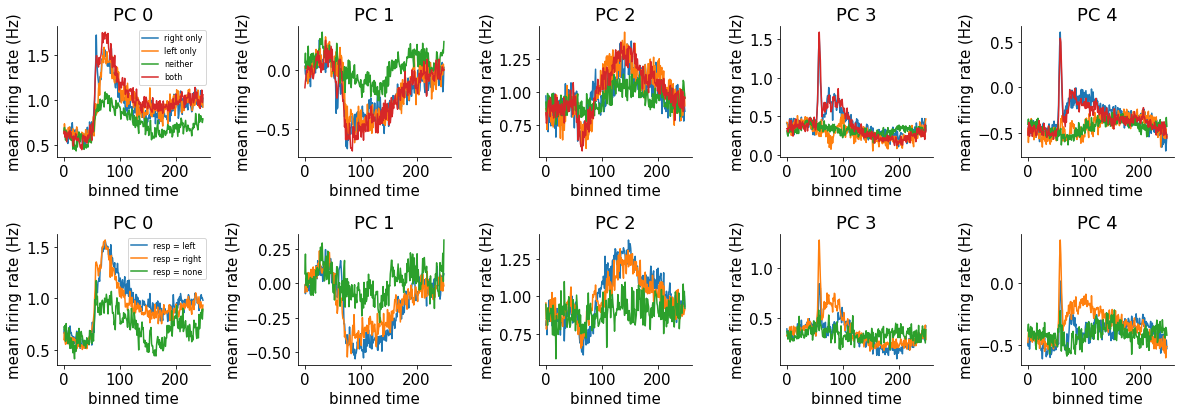

In [73]:
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left']   # 0 - low - high

plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
    ax = plt.subplot(2,len(pc_10ms)+1,j+1)
    pc1 = pc_10ms[j]

    plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
    plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
    plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
    plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))

    if j==0:
        plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
    ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
    plt.title('PC %d'%j)

    ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)

    plt.plot(pc1[response>0, :].mean(axis=0))  
    plt.plot(pc1[response<0, :].mean(axis=0))
    plt.plot(pc1[response==0, :].mean(axis=0))

    if j==0:
        plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
    ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
    plt.title('PC %d'%j)